In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
import pickle
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')
cmap = "RdBu_r"

from scipy.signal import stft, istft, get_window
from scipy.fftpack import fft, fftshift, fftfreq
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vectors_single_frequency,\
    compute_steering_vectors, simulate_multichannel_tf, compute_sinr,\
    compute_mvdr_tf_beamformers, check_distortless_constraint,\
    compute_mvndr_tf_beamformers, compute_lcmv_tf_beamformers,\
    compute_null_controlling_tf_beamformers,\
    compute_steering_vectors_circular, simulate_multichannel_tf_circular,\
    compute_minimum_variance_tf_beamformers
from dlbeamformers import BaseDLBeamformer, DLBeamformer
from dictionary_learning_beamformers import DictionaryLearningBeamformer
random_seed = 0

In [2]:
import os
from os import listdir
from os.path import join
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data_folder = join(datapath, 'train')
test_data_folder = join(datapath, 'test')

from scipy.io import wavfile
from IPython.display import Audio
train_data = []
test_data = []
train_data_filenames = [f for f in listdir(train_data_folder) if os.path.isfile( join(train_data_folder, f))]
test_data_filenames = [f for f in listdir(test_data_folder) if os.path.isfile( join(test_data_folder, f))]

for i_train_data_filename in range(len(train_data_filenames)):
    f_path = join(train_data_folder, train_data_filenames[i_train_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, train_data_example = wavfile.read(f_path)
    train_data.append(train_data_example)
    
min_test_length = np.inf
for i_test_data_filename in range(len(test_data_filenames)):
    f_path = join(test_data_folder, test_data_filenames[i_test_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, test_data_example = wavfile.read(f_path)
    test_example_length = len(test_data_example)
    if test_example_length > 32000:
        if test_example_length < min_test_length:
            min_test_length = test_example_length
        test_data.append(test_data_example)
for i_test in range(len(test_data)):
    test_data[i_test] = test_data[i_test][0:min_test_length]

In [3]:
from configparser import ConfigParser
config = ConfigParser()
config.read('config.INI');
params = config['PARAMS']
sampling_frequency = int(params['sampling_frequency'])
n_samples_per_frame = int(params['n_samples_per_frame'])
n_fft_bins = (int) (n_samples_per_frame / 2) 
hop_size = (int) (n_samples_per_frame / 2)
stft_window_name = params['stft_window_name']
stft_window = get_window("hann", n_samples_per_frame)
stft_params = {
    "n_samples_per_frame": n_samples_per_frame,
    "n_fft_bins": n_fft_bins,
    "hop_size": hop_size,
    "window": stft_window
}
max_f_index = 128

sound_speed = int(config["CONSTANTS"]["SOUND_SPEED"])
signal_max_freq = sampling_frequency / 2
min_wavelength = sound_speed / signal_max_freq

# Microphone positions
pos_x = np.array([-35.0, -35.0, 0.0, 35.0, 35.0, 0.0, 0.0]) * 1e-3
n_mics = len(pos_x)
pos_y = np.array([20.0, -20.0, -40.0, -20.0, 20.0, 40.0, 0.0]) * 1e-3
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))
# array_geometry.shape
np.sqrt(pos_x[0]*pos_x[0] + pos_y[0]*pos_y[0])

0.04031128874149275

In [4]:
(min_wavelength/2)

0.02125

In [5]:
# Source angles
azimuth_s = np.array([0]) # [degree]
# Angle grids
scanning_azimuth_grid = np.arange(-180, 180, 0.1) # [degree]

# Steering vectors
steering_vectors = compute_steering_vectors_circular(array_geometry, 
    sampling_frequency=sampling_frequency, azimuth_grid=scanning_azimuth_grid,
    stft_params=stft_params)
source_steering_vectors = compute_steering_vectors_circular(array_geometry, 
    sampling_frequency=sampling_frequency, azimuth_grid=azimuth_s,
    stft_params=stft_params)
# vs = compute_steering_vectors(array_geometry, sampling_frequency, n_fft_bins, 
#     theta_s, phi_s)

### DLBeamformer

In [6]:
# source_angles = [
#     {
#         "theta": np.array([-10]),
#         "phi": np.array([0])
#     }
# ]
# angle_grid = {
#     "theta": theta_grid,
#     "phi": phi_grid
# }
# dlbeamformer = DLBeamformer(array_geometry, sampling_frequency, source_angles,
#                            stft_params, angle_grid)
# assert np.allclose(vs, dlbeamformer.source_steering_vectors[0])
# assert np.allclose(steering_vectors, dlbeamformer.steering_vectors)

### Training data for null-controlling DL Beamformers - Circular

In [7]:
np.random.seed(random_seed)
n_interference_list = [1]

azimuth_step = 5
training_azimuths = list(np.arange(0, 360, azimuth_step))

n_training_samples = 70

training_tf_filename = "circular_CMU_ARCTIC_nc_tf_training_data_azimuth_step_{}_trainning_samples_{}.pkl".format(
    azimuth_step, n_training_samples
)
training_tf_path = "/data/dung/dictionary-beamforming-speech-enhancement/nc_tf_training_data"
training_tf_filepath = os.path.join(training_tf_path, training_tf_filename)

PREPARE_TF_DATA = True
import itertools
nc_training_interference_data = []
training_noise_interference_data = []
nc_training_interference_covariance = []
np.random.seed(random_seed)

if PREPARE_TF_DATA == True:
    for i_n_interference in tqdm_notebook(range(len(n_interference_list)), desc="Interference number"):
        n_interferences = n_interference_list[i_n_interference]
        interferences_params = []
        for i_interference in range(n_interferences):
            interference_params = list(itertools.product(*[training_azimuths]))
            interferences_params.append(interference_params)
        interferences_param_sets = list(itertools.product(*interferences_params))

        for i_param_set in tqdm_notebook(range(len(interferences_param_sets)), desc="Parameter set"):    
            param_set = interferences_param_sets[i_param_set]
            training_param_dict = {
                "azimuth": np.asarray(param_set).transpose()[0],
                }

            # MORE TRAINING DATA IS BETTER
            batch_size = n_training_samples
            tf_sample_covariance_batch = np.zeros((batch_size, n_fft_bins, n_mics, n_mics), dtype=np.complex64)
            for i_training_sample in range(n_training_samples):
                interference_signals = []
                for i_interference in range(len(param_set)):
                    interference_signal = train_data[np.random.choice(len(train_data))]
                    interference_signals.append(interference_signal)                
                interference_n_samples = min([len(signal) for signal in interference_signals])

                interference_tf_multichannel_list = []
                for i_interference in range(len(param_set)):
                    interference_signals[i_interference] = (interference_signals[i_interference])[0:interference_n_samples]
                    interference_azimuth = param_set[i_interference][0]
                    interference_azimuth += 1*np.random.uniform()
                    interference_tf_multichannel = simulate_multichannel_tf_circular(array_geometry, interference_signal, 
                            np.array([interference_azimuth]),
                            sampling_frequency, stft_params)
                    interference_tf_multichannel_list.append(interference_tf_multichannel)

                nc_training_interference_data.append((sum(interference_tf_multichannel_list), training_param_dict))

    with open(training_tf_filepath, 'wb') as output:
        pickle.dump(nc_training_interference_data, output, pickle.HIGHEST_PROTOCOL)
# else:
#     with open(training_tf_filepath, 'rb') as f:
#         nc_training_interference_data = pickle.load(f)

In [8]:
# desired_null_width = 5 # [degree]
# null_constraint_threshold = 0.001
# dlbeamformer.fit(nc_training_interference_data, desired_null_width, 
#                 null_constraint_threshold, eigenvalue_percentage_threshold=0.99)
# print(dlbeamformer.weights_.shape)

### Training data for null-controlling Dictionary Learning Beamformers

In [9]:
np.random.seed(random_seed)
# n_interference_list = [1]

# azimuth_step = 5
# training_thetas = list(np.arange(-90, 90, azimuth_step))
# training_phis = [0]

n_samples_each_config = len(train_data)
# n_samples_each_config = 1
PREPARE_COVARIANCE_DATA = True

training_tf_filename = "circular_CMU_ARCTIC_nc_tf_training_covariance_data_azimuth_step_{}_config_trainning_samples_{}.pkl".format(
        azimuth_step, n_samples_each_config
    )
training_tf_path = "/data/dung/dictionary-beamforming-speech-enhancement/nc_tf_training_data"
training_tf_filepath = os.path.join(training_tf_path, training_tf_filename)
    
if PREPARE_COVARIANCE_DATA == True:
    import itertools
    nc_training_interference_covariance = []
    np.random.seed(random_seed)
    for i_n_interference in tqdm_notebook(range(len(n_interference_list)), desc="Interference number"):
        n_interferences = n_interference_list[i_n_interference]
        interferences_params = []
        for i_interference in range(n_interferences):
            interference_params = list(itertools.product(*[training_azimuths]))
            interferences_params.append(interference_params)
        interferences_param_sets = list(itertools.product(*interferences_params))

        for i_param_set in tqdm_notebook(range(len(interferences_param_sets)), desc="Parameter set"):    
            param_set = interferences_param_sets[i_param_set]
            training_param_dict = {
                "azimuth": np.asarray(param_set).transpose()[0],
                }

            # MORE TRAINING DATA IS BETTER            
            tf_sample_covariance_batch = np.zeros((n_samples_each_config, n_fft_bins, n_mics, n_mics), dtype=np.complex64)
            for i_training_sample in range(n_samples_each_config):
                interference_signals = []
                for i_interference in range(len(param_set)):
                    interference_signal = train_data[np.random.choice(len(train_data))]
                    interference_signals.append(interference_signal)                
                interference_n_samples = min([len(signal) for signal in interference_signals])

                interference_tf_multichannel_list = []
                for i_interference in range(len(param_set)):
                    interference_signals[i_interference] = (interference_signals[i_interference])[0:interference_n_samples]
                    interference_azimuth = param_set[i_interference][0]
                    interference_azimuth += 1*np.random.uniform()
                    interference_tf_multichannel = simulate_multichannel_tf_circular(array_geometry, interference_signal, 
                            np.array([interference_azimuth]),
                            sampling_frequency, stft_params)
                    interference_tf_multichannel_list.append(interference_tf_multichannel)

                received = sum(interference_tf_multichannel_list)
                received_sample_covariance = np.zeros((n_fft_bins, n_mics, n_mics), dtype=np.complex64)
                n_received_samples = received.shape[2]
                for i_fft_bin in range(n_fft_bins):
                    received_sample_covariance[i_fft_bin] = 1/n_received_samples * received[i_fft_bin].dot(received[i_fft_bin].transpose().conjugate())
                tf_sample_covariance_batch[i_training_sample] = received_sample_covariance
            nc_training_interference_covariance.append((tf_sample_covariance_batch, training_param_dict))
            
    with open(training_tf_filepath, 'wb') as f:
        pickle.dump(nc_training_interference_covariance, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(training_tf_filepath, 'rb') as f:
        nc_training_interference_covariance = pickle.load(f)

In [35]:
# np.allclose(dlbeamformer.weights_, dictionary_learning_beamformer.weights_)
nc_training_interference_covariance[0][1]

{'azimuth': array([0])}

In [11]:
# dict_filename = "null_controlling_dl_azimuth_step_{}_trainning_samples_{}.pkl".format(
#     azimuth_step, n_training_samples
# )
# train_models_path = "/data/dung/dictionary-beamforming-speech-enhancement/trained_models"
# dict_filepath = os.path.join(train_models_path, dict_filename)
# with open(dict_filepath, 'wb') as output:
#     pickle.dump(dictionary, output, pickle.HIGHEST_PROTOCOL)

In [12]:
# Simulate received multichannel signal
np.random.seed(1)

# Test signals
i_test = np.random.choice(len(test_data))
source_signal = test_data[i_test]
# source_signal = test_data[0]
n_test_samples = len(source_signal)
interference_signals = []
for i_interference in range(2):
    i_test = np.random.choice(len(test_data))
    interference_signals.append(test_data[i_test])
    
# Interference angles
azimuths_i = np.array([87]) # [degree]
# thetas_i = np.random.uniform(low=-90, high=90, size=1)

time_samples = np.arange(0, n_test_samples)/sampling_frequency    

source_stft_multichannel = simulate_multichannel_tf_circular(array_geometry, source_signal, azimuth_s,
                                sampling_frequency, stft_params)

received_stft_multichannel = np.zeros(source_stft_multichannel.shape, dtype=np.complex64)

received_stft_multichannel += source_stft_multichannel

interference_stfts_multichannel_list = []

for i_angle in range(len(azimuths_i)):
    interference_signal = interference_signals[i_angle]
    
    interference_stft_multichannel = simulate_multichannel_tf_circular(array_geometry, interference_signal, 
                                        np.array([azimuths_i[i_angle]]),
                                        sampling_frequency, stft_params)

    interference_stfts_multichannel_list.append(interference_stft_multichannel)
    
    received_stft_multichannel += interference_stft_multichannel
    
interference_stfts_multichannel = sum(interference_stfts_multichannel_list)

Input SINR: 0.96 dB


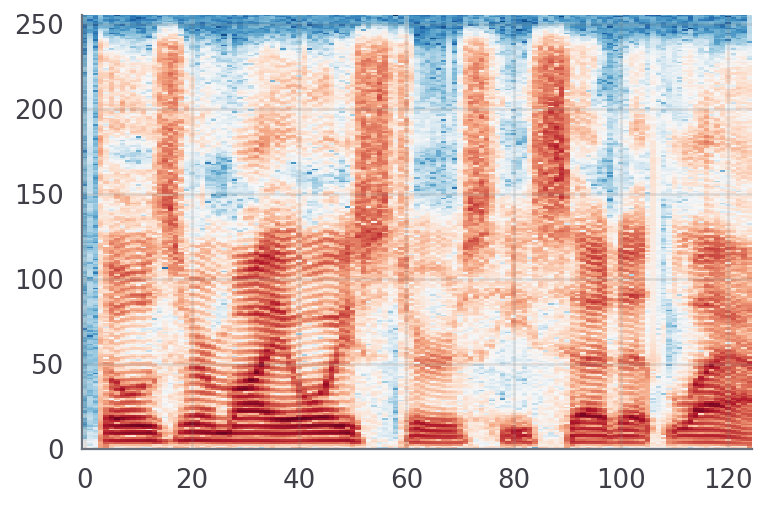

In [13]:
# Listen to the simulated received signal
t, ss = istft(np.real(source_stft_multichannel[:, 0, :]), fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(source_stft_multichannel[:, 0, :])), origin='lower', aspect='auto', cmap=cmap)
input_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel)
print("Input SINR: {:.2f} dB".format(input_sinr))
Audio(np.real(ss), rate=sampling_frequency, autoplay=True)

### Beamformers and outputs

Output SINR: 1.93 dB


True

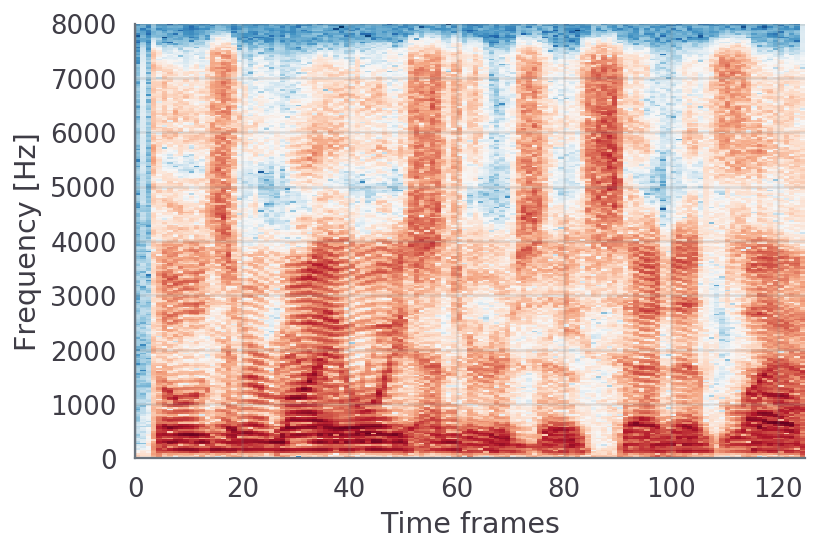

In [14]:
# Delay-sum beamformer
ds_tf_beamformers = 1./n_mics * source_steering_vectors
ds_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    ds_tf_out[i_fft_bin] = ds_tf_beamformers[i_fft_bin, 0].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, ds_out_2 = istft(ds_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)    

plt.imshow(10*np.log10(np.abs(ds_tf_out)), origin='lower', aspect='auto', cmap=cmap,
          extent=[0, ds_tf_out.shape[1], 0, sampling_frequency/2])
plt.xlabel("Time frames"); plt.ylabel("Frequency [Hz]");
ds_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, ds_tf_beamformers[:, 0, :])
print("Output SINR: {:.2f} dB".format(ds_out_sinr[0][0]))
Audio(np.real(ds_out_2), rate=sampling_frequency, autoplay=True)

mvb = compute_minimum_variance_tf_beamformers(source_steering_vectors[:, 0, :], tf_frames_multichannel=None, diagonal_loading_param=1)
np.allclose(ds_tf_beamformers[:, 0, :], mvb)

In [15]:
mvb.shape

(256, 7)

MPDR output SINR: 2.21 dB


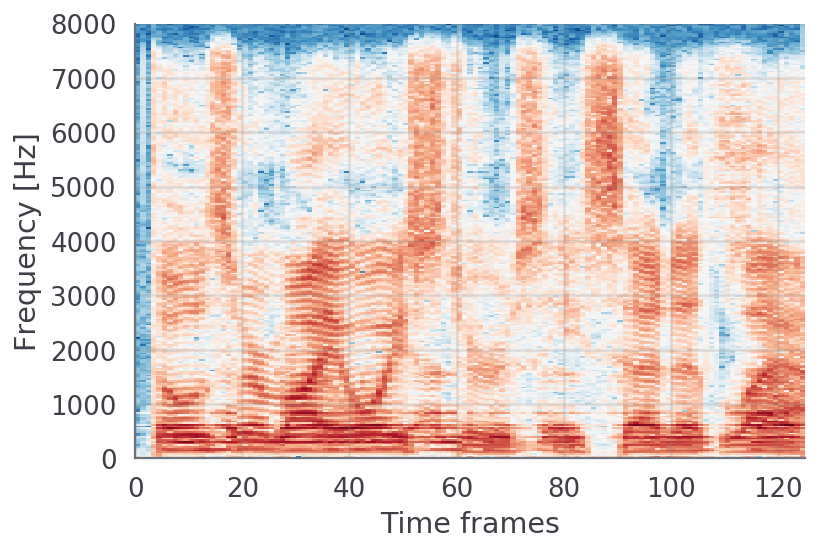

In [16]:
import importlib
import dlbeamformer_utilities
importlib.reload(dlbeamformer_utilities)
from dlbeamformer_utilities import compute_mvdr_tf_beamformers

mpdr_tf_beamformers = compute_mvdr_tf_beamformers(source_steering_vectors[:, 0, :], received_stft_multichannel)
mpdr_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mpdr_tf_out[i_fft_bin] = mpdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mpdr_out = istft(mpdr_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mpdr_tf_out)), origin='lower', aspect='auto', cmap=cmap,
          extent=[0, ds_tf_out.shape[1], 0, sampling_frequency/2])
plt.xlabel("Time frames"); plt.ylabel("Frequency [Hz]");
mpdr_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mpdr_tf_beamformers)
print("MPDR output SINR: {:.2f} dB".format(mpdr_out_sinr[0][0]))
Audio(np.real(mpdr_out), rate=sampling_frequency, autoplay=True)

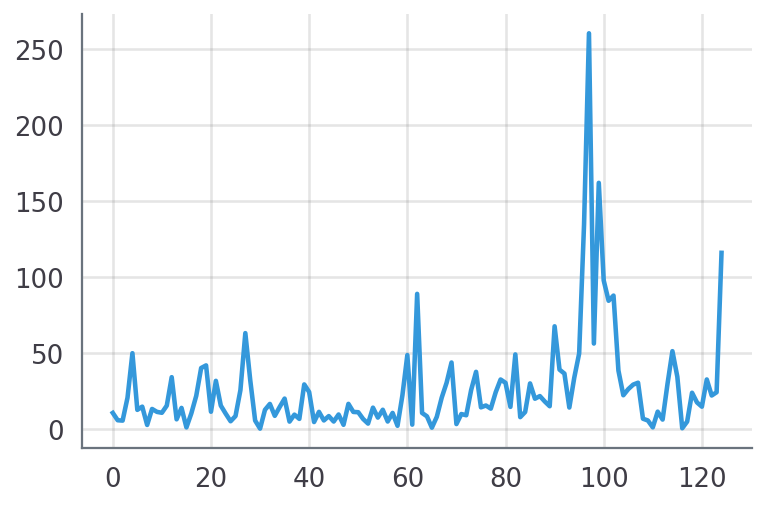

In [17]:
plt.plot(np.abs(mpdr_tf_out[0]));

MVDR output SINR: 36.84 dB


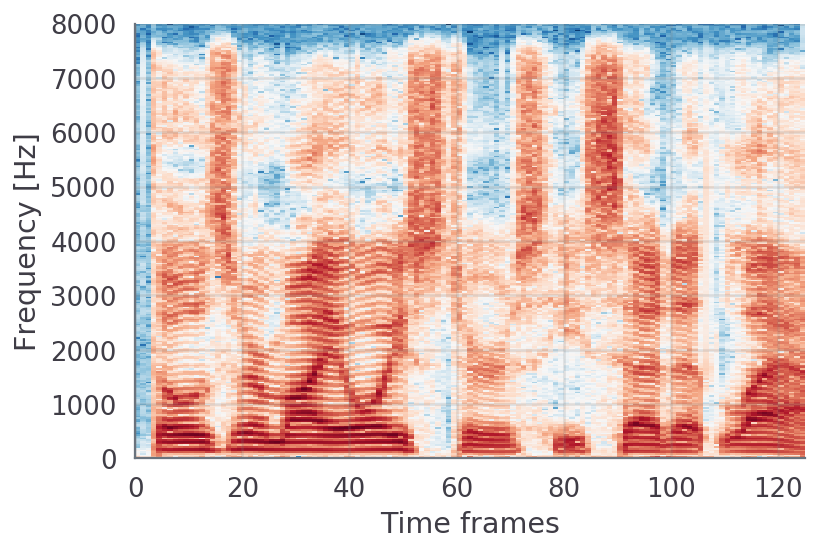

In [18]:
mvdr_tf_beamformers = compute_mvdr_tf_beamformers(source_steering_vectors[:, 0, :],
            tf_frames_multichannel=interference_stfts_multichannel,
            diagonal_loading_param=1)
# mvdr_tf_beamformers = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
# diagonal_loading_param = 1
# for i_fft_bin in range(n_fft_bins):
#     n_frames = interference_stfts_multichannel.shape[2]
# #     diagonal_loading_param = received_stft_multichannel[i_fft_bin].transpose().conjugate().dot(
# #     received_stft_multichannel[i_fft_bin])*1e-3
#     R = 1./n_frames * received_stft_multichannel[i_fft_bin].dot(
#         received_stft_multichannel[i_fft_bin].transpose().conjugate())\
#         + diagonal_loading_param*np.identity(n_mics) 
#     invR = np.linalg.inv(R)
#     normalization_factor = source_steering_vectors[i_fft_bin][0].transpose().conjugate().dot(
#         invR).dot(source_steering_vectors[i_fft_bin][0])
#     mvdr_tf_beamformers[i_fft_bin] = invR.dot(source_steering_vectors[i_fft_bin][0]) / normalization_factor
#     check_distortless_constraint(mvdr_tf_beamformers[i_fft_bin], source_steering_vectors[i_fft_bin][0])
mvdr_tf_beamformers = compute_minimum_variance_tf_beamformers(source_steering_vectors[:, 0, :], 
    tf_frames_multichannel=interference_stfts_multichannel, diagonal_loading_param=1)
mvdr_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mvdr_tf_out[i_fft_bin] = mvdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mvdr_out = istft(mvdr_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mvdr_tf_out)), origin='lower', aspect='auto', cmap=cmap,
          extent=[0, mvdr_tf_out.shape[1], 0, sampling_frequency/2])
plt.xlabel("Time frames"); plt.ylabel("Frequency [Hz]");           
mvdr_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mvdr_tf_beamformers)
print("MVDR output SINR: {:.2f} dB".format(mvdr_out_sinr[0][0]))
Audio(np.real(mvdr_out), rate=sampling_frequency, autoplay=True)

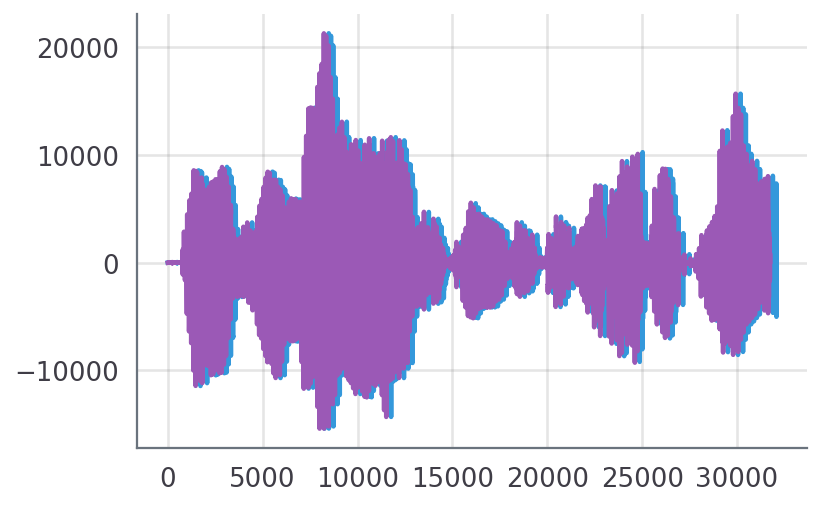

In [19]:
plt.plot(source_signal);
plt.plot(np.real(mvdr_out));

In [20]:
theta_nulling = np.array([27, 29, 31, 33, 35])
theta_all = np.hstack((theta_s, theta_nulling))
phi_all = np.zeros([1])
lcmv_constraint_vector = np.zeros(theta_nulling.shape[0] + 1)
lcmv_constraint_vector[0] = 1
# theta_all = theta_s
# lcmv_constraint_vector = np.array([1])
lcmv_steering_vectors = compute_steering_vectors(array_geometry, sampling_frequency=sampling_frequency, 
                                    n_fft=n_fft_bins, theta_grid=theta_all, phi_grid=phi_all) 
C = np.transpose(lcmv_steering_vectors[:, :, 0, :], (0, 2, 1))
lcmv_tf_beamformers = compute_lcmv_tf_beamformers(C, interference_stft_multichannel, lcmv_constraint_vector)
lcmv_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    lcmv_tf_out[i_fft_bin] = lcmv_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, lcmv_out = istft(lcmv_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(lcmv_tf_out)), origin='lower', aspect='auto', cmap=cmap)
lcmv_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, lcmv_tf_beamformers)
print("LCMV output SINR: {:.2f} dB".format(lcmv_out_sinr[0][0]))
Audio(np.real(lcmv_out), rate=sampling_frequency, autoplay=True)

NameError: name 'theta_s' is not defined

In [ ]:
# theta_nulling = np.hstack((np.arange(2.5, 7.5, .1), np.arange(27.5, 32.5, .1)))
azimuth_nulling = np.arange(84.5, 89.5, .1)
azimuth_all = np.hstack((azimuth_s, azimuth_nulling))

################################################################################
# SANITY CHECK: this should result in a beam pattern similar to that of MVDR
# theta_nulling = theta_s
################################################################################
null_steering_vectors = compute_steering_vectors_circular(array_geometry, sampling_frequency=sampling_frequency, 
                                    azimuth_grid=azimuth_all, stft_params=stft_params) 
null_steering_vectors = np.transpose(null_steering_vectors[:, :, :], (0, 2, 1))
null_constraint_threshold = 0.01
nc_tf_beamformers = compute_null_controlling_tf_beamformers(source_steering_vectors[:, 0, :], 
                null_steering_vectors, interference_stft_multichannel, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99)
nc_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    nc_tf_out[i_fft_bin] = nc_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, nc_out = istft(nc_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(nc_tf_out)), origin='lower', aspect='auto', cmap=cmap)
nc_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, nc_tf_beamformers)
print("NC output SINR: {:.2f} dB".format(nc_out_sinr[0][0]))

fig = plt.figure();

ax = fig.add_subplot(211)
N = len(nc_out)
fft_nc = fftshift(fft(nc_out) / N)
freqs = fftshift(fftfreq(N, 1/sampling_frequency))
ax.plot(freqs, np.abs(fft_nc), alpha=0.5)

N = len(source_signal)
fft_source = fftshift(fft(source_signal) / N)
freqs = fftshift(fftfreq(N, 1/sampling_frequency))
ax.plot(freqs, np.abs(fft_source), alpha=0.5)

ax = fig.add_subplot(212)
ax.plot(source_signal)
ax.plot(nc_out)
# Audio(np.real(nc_tf_out), rate=sampling_frequency, autoplay=True)

In [ ]:
source_angle_index = 0
nc_dl_tf_beamformers = dlbeamformer.choose_weights(source_angle_index, 
                            interference_stfts_multichannel)
nc_dl_tf_out = np.zeros((n_fft_bins, interference_stfts_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    nc_dl_tf_out[i_fft_bin] = nc_dl_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, nc_dl_out = istft(nc_dl_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(nc_dl_tf_out)), origin='lower', aspect='auto', cmap=cmap)
nc_dl_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, nc_dl_tf_beamformers)
print("Null controlling DL output SINR: {:.2f} dB".format(nc_dl_out_sinr[0][0]))
Audio(np.real(nc_dl_out), rate=sampling_frequency, autoplay=True)

In [ ]:
fig = plt.figure();

ax = fig.add_subplot(211)
N = len(nc_dl_out)
fft_dl = fftshift(fft(nc_dl_out) / N)
freqs = fftshift(fftfreq(N, 1/sampling_frequency))
ax.plot(freqs, np.abs(fft_dl), alpha=0.5)

N = len(source_signal)
fft_source = fftshift(fft(source_signal) / N)
freqs = fftshift(fftfreq(N, 1/sampling_frequency))
ax.plot(freqs, np.abs(fft_source), alpha=0.5)

ax = fig.add_subplot(212)
ax.plot(source_signal)
ax.plot(nc_dl_out)

In [43]:
###
# TRAIN NULL-CONTROLLING DICTIONARY LEARNING BEAMFORMER
###
import importlib
import dictionary_learning_beamformers_circular
importlib.reload(dictionary_learning_beamformers_circular)
from dictionary_learning_beamformers_circular import DictionaryLearningBeamformerCircular

source_angles = [
    {
        "azimuth": azimuth_s
    }
]
angle_grid = {
    "azimuth": scanning_azimuth_grid
}

dictionary_learning_beamformer_circular = DictionaryLearningBeamformerCircular(array_geometry, sampling_frequency, source_angles,
                           stft_params, angle_grid, diagonal_loading_param=1)
desired_null_width = 5 # [degree]
null_constraint_threshold = 0.001
dictionary_learning_beamformer_circular.fit(nc_training_interference_covariance, desired_null_width, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99,
                batch_size=900, n_atoms_each_config=1);
print(dictionary_learning_beamformer_circular.weights_.shape)

Training configuration: 100%|██████████| 72/72 [00:11<00:00,  7.82it/s]

(1, 256, 7, 72)


In [37]:
steering_vectors.shape

(256, 3600, 7)

FFT bin: 100%|██████████| 256/256 [00:00<00:00, 2419.06it/s]

Null controlling Dictionary Learning output SINR: 36.67 dB


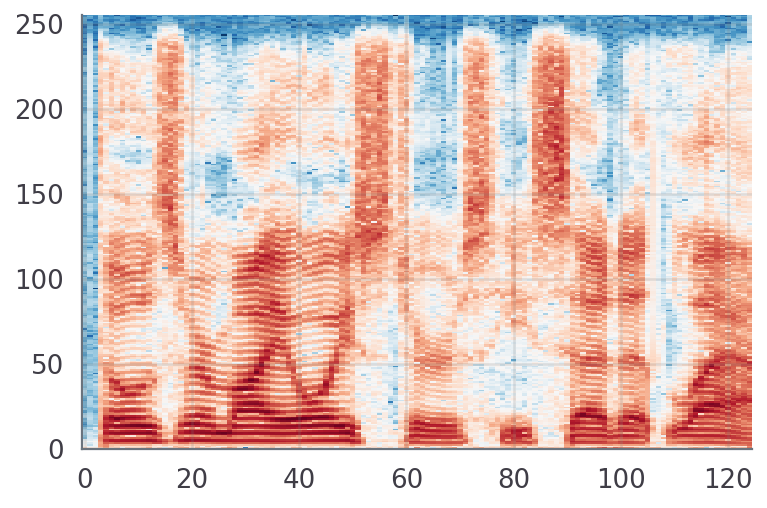

In [45]:
source_angle_index = 0
nc_dictlearn_tf_beamformers_circular = dictionary_learning_beamformer_circular.choose_weights(source_angle_index, 
                            interference_stfts_multichannel)
nc_dictlearn_tf_out = np.zeros((n_fft_bins, interference_stfts_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    nc_dictlearn_tf_out[i_fft_bin] = nc_dictlearn_tf_beamformers_circular[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, nc_dictlearn_out = istft(nc_dictlearn_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)
# assert np.allclose(nc_dl_tf_out, nc_dictlearn_tf_out)
plt.imshow(10*np.log10(np.abs(nc_dictlearn_tf_out)), origin='lower', aspect='auto', cmap=cmap)
nc_dictlearn_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, nc_dictlearn_tf_beamformers_circular)
print("Null controlling Dictionary Learning output SINR: {:.2f} dB".format(nc_dictlearn_out_sinr[0][0]))
min_len = min(len(source_signal), len(nc_dictlearn_out))
Audio(np.real(nc_dictlearn_out), rate=sampling_frequency, autoplay=True)

In [ ]:
min_len

In [ ]:
Audio(np.real(nc_dl_out), rate=sampling_frequency, autoplay=True)
# wavfile.write("Null_controlling_DLBeamformer_output.wav", 
#               rate=sampling_frequency, data = np.real(nc_dl_out))
# import soundfile as sf
# sf.write('null_controlling_DLBeamformer_output.flac', np.real(nc_dl_out), sampling_frequency)

In [49]:
a = np.array([1])
a.reshape(-1, 1)

array([[1]])

### Beam pattern

In [ ]:
# Delay-sum beam pattern
ds_tf_beampattern = np.zeros((n_fft_bins, len(scanning_azimuth_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
        for i_phi in range(len(scanning_azimuth_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_phi]
            ds_tf_beampattern[i_fft_bin][i_phi] = ds_tf_beamformers[i_fft_bin, 0, :].transpose().conjugate().dot(
            scanning_steering_vector)

ds_tf_beampattern_normalized = np.abs(ds_tf_beampattern)/np.max(np.abs(ds_tf_beampattern))
ds_tf_beampattern_db = 20*np.log10(ds_tf_beampattern_normalized);

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [63, 127, 255]
for i_f in i_frequencies:
    ax.plot(scanning_azimuth_grid, ds_tf_beampattern_db[i_f, :],
            label="{:.0f} Hz".format(i_f/n_fft_bins*(sampling_frequency/2)));
# ax.axvline(x=azimuth_s[0], linestyle="--", color=flatui[1], label="Source angle");
# for i_interference in range(0, len(azimuths_i)):
#     ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(scanning_azimuth_grid[0], scanning_azimuth_grid[-1]);
ax.set_xlabel(r"$\phi$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Delay-sum TF beam patterns")
ax.legend();

ds_ave_beampattern = np.mean(np.abs(ds_tf_beampattern[:32, :]), axis=0)
ds_ave_beampattern_normalized = ds_ave_beampattern / np.max(ds_ave_beampattern)
ds_ave_beampattern_normalized_db = 20*np.log10(ds_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(scanning_azimuth_grid, ds_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=azimuth_s[0], linestyle="--", color=flatui[1], label="Source angle");
# for i_interference in range(0, len(azimuths_i)):
#     ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(scanning_azimuth_grid[0], scanning_azimuth_grid[-1]); ax.set_ylim(-60, 1)
ax.set_xlabel(r"$\phi$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Delay-sum TF average beam pattern")
ax.legend();

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
img = ax.imshow(np.abs(ds_tf_beampattern), aspect="auto", origin="lower",
          extent=[scanning_azimuth_grid[0], scanning_azimuth_grid[-1], 0, sampling_frequency/2 * 1e-3],
          cmap="coolwarm");
ax.set_xlabel("Azimuth angle [degree]"); ax.set_ylabel("Frequency [Kz]");
ax.grid(False)
plt.colorbar(img);

In [ ]:
# MVDR beam pattern
mvdr_tf_beampattern = np.zeros((n_fft_bins, len(scanning_azimuth_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
        for i_phi in range(len(scanning_azimuth_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_phi]
            mvdr_tf_beampattern[i_fft_bin][i_phi] = mvdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

# mvdr_tf_beampattern_normalized = np.abs(mvdr_tf_beampattern)/np.max(np.abs(mvdr_tf_beampattern))
mvdr_tf_beampattern_db = 20*np.log10(np.abs(mvdr_tf_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [1, 7, 31, 63, 127, 255]
for i_f in i_frequencies:
    ax.plot(scanning_azimuth_grid, mvdr_tf_beampattern_db[i_f, :], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=azimuth_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(azimuths_i)):
    ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-180, 180);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MVDR TF beam patterns")
ax.legend();

mvdr_ave_beampattern = np.mean(np.abs(mvdr_tf_beampattern[0:max_f_index, :]), axis=0)
mvdr_ave_beampattern_normalized = mvdr_ave_beampattern / np.max(mvdr_ave_beampattern)
mvdr_ave_beampattern_normalized_db = 20*np.log10(mvdr_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(scanning_azimuth_grid, mvdr_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=azimuth_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(azimuths_i)):
    ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(scanning_azimuth_grid[0], scanning_azimuth_grid[-1]); ax.set_ylim(-50, 1)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MVDR TF average beam pattern")
ax.legend();

In [ ]:
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
img = ax.imshow((mvdr_tf_beampattern_db), aspect="auto", origin="lower", 
          extent=[scanning_azimuth_grid[0], scanning_azimuth_grid[-1], 0, sampling_frequency/2],
          cmap="coolwarm");
plt.colorbar(img);

In [ ]:
# LCMV beam pattern
lcmv_tf_beampattern = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            lcmv_tf_beampattern[i_fft_bin][i_theta][i_phi] = lcmv_tf_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

# mvdr_tf_beampattern_normalized = np.abs(mvdr_tf_beampattern)/np.max(np.abs(mvdr_tf_beampattern))
lcmv_tf_beampattern_db = 20*np.log10(np.abs(lcmv_tf_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [10, 30, 50]
for i_f in i_frequencies:
    ax.plot(theta_grid, lcmv_tf_beampattern_db[i_f, :, 0], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("LCMV TF beam patterns")
ax.legend();

lcmv_ave_beampattern = np.mean(np.abs(lcmv_tf_beampattern[:, :, 0]), axis=0)
lcmv_ave_beampattern_normalized = lcmv_ave_beampattern / np.max(lcmv_ave_beampattern)
lcmv_ave_beampattern_normalized = lcmv_ave_beampattern
lcmv_ave_beampattern_normalized_db = 20*np.log10(lcmv_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, lcmv_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90); ax.set_ylim(-15, 10)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("LCMV TF average beam pattern")
ax.legend();

In [ ]:
# Null-controlling beam pattern
nc_tf_beampattern = np.zeros((n_fft_bins, len(scanning_azimuth_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
        for i_phi in range(len(scanning_azimuth_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_phi]
            nc_tf_beampattern[i_fft_bin][i_phi] = nc_tf_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

# mvdr_tf_beampattern_normalized = np.abs(mvdr_tf_beampattern)/np.max(np.abs(mvdr_tf_beampattern))
nc_tf_beampattern_db = 20*np.log10(np.abs(nc_tf_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [10, 30, 50]
for i_f in i_frequencies:
    ax.plot(scanning_azimuth_grid, nc_tf_beampattern_db[i_f, :, 0], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(azimuths_i)):
    ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling TF beam patterns")
ax.legend();

nc_ave_beampattern = np.mean(np.abs(nc_tf_beampattern[0:max_f_index, :, 0]), axis=0)
nc_ave_beampattern_normalized = nc_ave_beampattern / np.max(nc_ave_beampattern)
# nc_ave_beampattern_normalized = nc_ave_beampattern
nc_ave_beampattern_normalized_db = 20*np.log10(nc_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(scanning_azimuth_grid, nc_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=azimuth_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(azimuths_i)):
    ax.axvline(x=azimuths_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90); ax.set_ylim(-60, 1)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling TF average beam pattern")
ax.legend();

In [ ]:
# Null-controlling DL beam pattern
nc_dl_tf_beampattern = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            nc_dl_tf_beampattern[i_fft_bin][i_theta][i_phi] = nc_dl_tf_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

# mvdr_tf_beampattern_normalized = np.abs(mvdr_tf_beampattern)/np.max(np.abs(mvdr_tf_beampattern))
nc_dl_tf_beampattern_db = 20*np.log10(np.abs(nc_dl_tf_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [30, 60, 90]
for i_f in i_frequencies:
    ax.plot(theta_grid, nc_dl_tf_beampattern_db[i_f, :, 0], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling DL TF beam patterns")
ax.legend();

nc_dl_ave_beampattern = np.mean(np.abs(nc_dl_tf_beampattern[0:max_f_index, :, 0]), axis=0)
nc_dl_ave_beampattern_normalized = nc_dl_ave_beampattern / np.max(nc_dl_ave_beampattern)
nc_ave_beampattern_normalized = nc_dl_ave_beampattern
nc_dl_ave_beampattern_normalized_db = 20*np.log10(nc_dl_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, nc_dl_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90); ax.set_ylim(-60, 1)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling DL TF average beam pattern")
ax.legend();

In [ ]:
# MPDR beam pattern
mpdr_tf_beampattern = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            mpdr_tf_beampattern[i_fft_bin][i_theta][i_phi] = mpdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

# mvdr_tf_beampattern_normalized = np.abs(mvdr_tf_beampattern)/np.max(np.abs(mvdr_tf_beampattern))
mpdr_tf_beampattern_db = 20*np.log10(np.abs(mpdr_tf_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [10, 20, 30, 40, 50]
for i_f in i_frequencies:
    ax.plot(theta_grid, mpdr_tf_beampattern_db[i_f, :, 0], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MPDR TF beam patterns")
ax.legend();

mpdr_ave_beampattern = np.mean(np.abs(mpdr_tf_beampattern[:, :, 0]), axis=0)
mpdr_ave_beampattern_normalized = mpdr_ave_beampattern / np.max(mpdr_ave_beampattern)
mpdr_ave_beampattern_normalized_db = 20*np.log10(mpdr_ave_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, mpdr_ave_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90); ax.set_ylim(-20, 1)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MPDR TF average beam pattern")
ax.legend();